In [1]:
# Omporting required library
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot as auto_corr

# imports for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# Ignoring Warnings
import warnings
warnings.filterwarnings("ignore")

# imports for model, sesional decomposition, metrics
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# imports for timeseries predictions
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip3 install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00


### Data Loading

In [2]:
# Importing data

store_df = pd.read_csv('./sample_data/data/stores.csv')
features_df = pd.read_csv('./sample_data/data/features.csv')
train_df = pd.read_csv('./sample_data/data/train.csv')
test_df = pd.read_csv('./sample_data/data/test.csv')

In [3]:
store_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


### Date Preparation

In [7]:
# Making a complete datframe from these 3 data frames

df = train_df.merge(features_df, on=['Store', 'Date'], how='inner').merge(store_df, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [8]:
# merging has created 2 holiday columns lets drop one and rename it to holiday

df.drop(['IsHoliday_y'], axis=1,inplace=True)
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [9]:
df.shape

(421570, 16)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [11]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


### Data Analysis

In [12]:
# lets check for nulls in the data frame
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [13]:
# we see that Markdown columns have nulls so lets drop them to avoid any issues with data analysis and modeling
df_not_null = df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis = 1)
df_not_null.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [14]:
df_not_null.shape

(421570, 11)

In [15]:
df_not_null.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000


### Lets do processing on this dataframe further

In [16]:
sales_df = df_not_null

In [17]:
### lets have a look at our target attribute to see if we have any curropted data
sales_df.loc[sales_df['Weekly_Sales']<=0].count()

Store           1358
Dept            1358
Date            1358
Weekly_Sales    1358
IsHoliday       1358
Temperature     1358
Fuel_Price      1358
CPI             1358
Unemployment    1358
Type            1358
Size            1358
dtype: int64

#### We have 1358 rows with negative sales value which looks corrupted, so lets drop them

In [18]:
sales_df = sales_df.loc[sales_df['Weekly_Sales'] > 0]

In [19]:
sales_df.shape

(420212, 11)

In [20]:
sales_df['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [21]:
sales_df.groupby('Type').sum('Weekly_Sales')[['Weekly_Sales']]

,Weekly_Sales
Type,
A,4.331057e+09
B,2.000742e+09
C,4.055080e+08


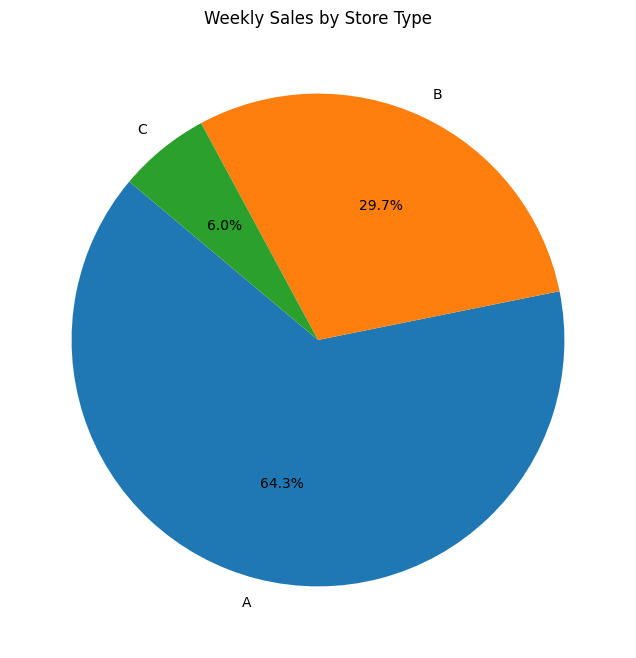

In [22]:
data = {'Weekly_Sales': [4.331057e+09, 2.000742e+09, 4.055080e+08]}
index = ['A', 'B', 'C']
df = pd.DataFrame(data, index=index)

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['Weekly_Sales'], labels=df.index, autopct='%1.1f%%', startangle=140)
plt.title('Weekly Sales by Store Type')
plt.show()

In [23]:
sales_df.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,214961.0,182225.39,41532.66,39690.0,158114.0,202505.0,203819.0,219622.0
B,162787.0,101796.84,30944.31,34875.0,93188.0,114533.0,123737.0,140167.0
C,42464.0,40536.10,1194.69,39690.0,39690.0,39910.0,41062.0,42988.0


#### Type A store has the highest sales as per the above analysis and pie chart

In [24]:
sales_df['Store'].nunique()

45

In [25]:
sales_df['Dept'].nunique()

81

In [26]:
sales_df['Date'].head(5).append(sales_df['Date'].tail(5))
# We have data from February 2010 till October 2012

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

### Lets look at some attribute which might affect sales and we know holidays do affect sales

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

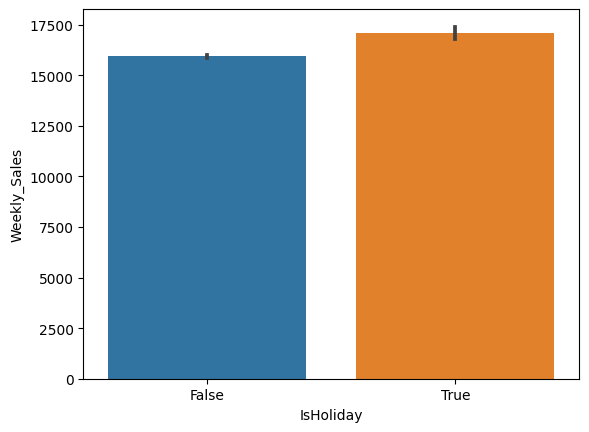

In [27]:
# Analysing holidays sales week data
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=sales_df)

We see that during holidays the sales spikes than normal weeks

In [28]:
holiday_df = sales_df.loc[sales_df['IsHoliday']==True]
holiday_df['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

Lets identify these holidays from the calander and create its columns as Superbowl, Labor_day, ThanksGiving, Christmas

In [29]:
sales_df.loc[(sales_df['Date'] == '2010-02-12')|(sales_df['Date'] == '2011-02-11')|(sales_df['Date'] == '2012-02-10'),'Super_Bowl'] = True
sales_df.loc[(sales_df['Date'] != '2010-02-12')&(sales_df['Date'] != '2011-02-11')&(sales_df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [30]:
sales_df.loc[(sales_df['Date'] == '2010-09-10')|(sales_df['Date'] == '2011-09-09')|(sales_df['Date'] == '2012-09-07'),'Labor_Day'] = True
sales_df.loc[(sales_df['Date'] != '2010-09-10')&(sales_df['Date'] != '2011-09-09')&(sales_df['Date'] != '2012-09-07'),'Labor_Day'] = False

sales_df.loc[(sales_df['Date'] == '2010-11-26')|(sales_df['Date'] == '2011-11-25'),'Thanksgiving'] = True
sales_df.loc[(sales_df['Date'] != '2010-11-26')&(sales_df['Date'] != '2011-11-25'),'Thanksgiving'] = False

sales_df.loc[(sales_df['Date'] == '2010-12-31')|(sales_df['Date'] == '2011-12-30'),'Christmas'] = True
sales_df.loc[(sales_df['Date'] != '2010-12-31')&(sales_df['Date'] != '2011-12-30'),'Christmas'] = False

In [31]:
sales_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,192.308899,8.667,B,118221,False,False,False,False
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,192.308899,8.667,B,118221,False,False,False,False
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,192.308899,8.667,B,118221,False,False,False,False
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,192.308899,8.667,B,118221,False,False,False,False


We have classified the holidays in the major holidays so we dont need to look at the dates for holidays anymore

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

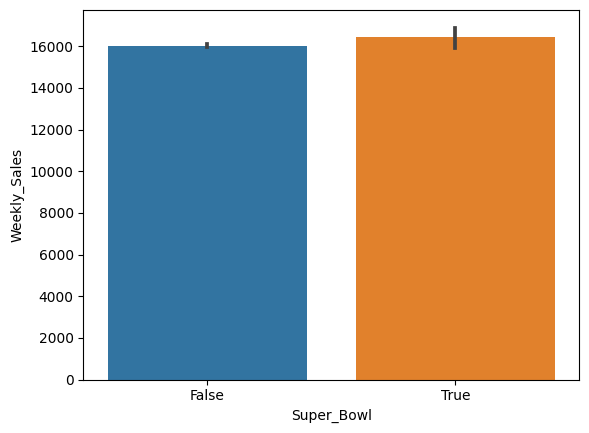

In [32]:
# Sales for super bowl weeks vs other days
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=sales_df)

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

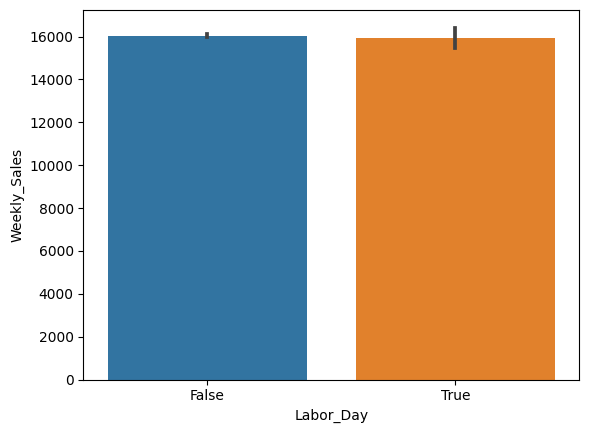

In [33]:
# Sales for Labor Day weeks vs other days
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=sales_df)

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

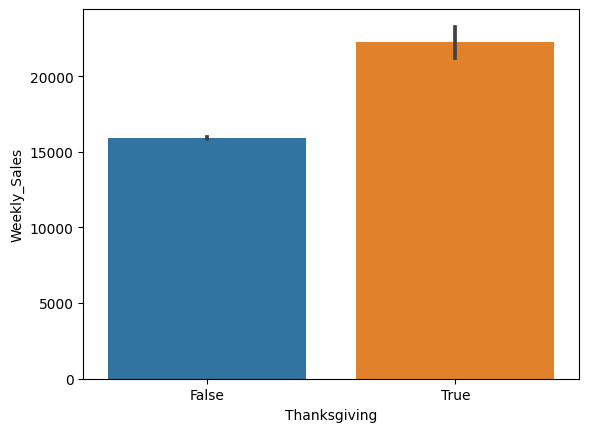

In [34]:
# Sales for Thanks Giving weeks vs other days
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=sales_df)

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

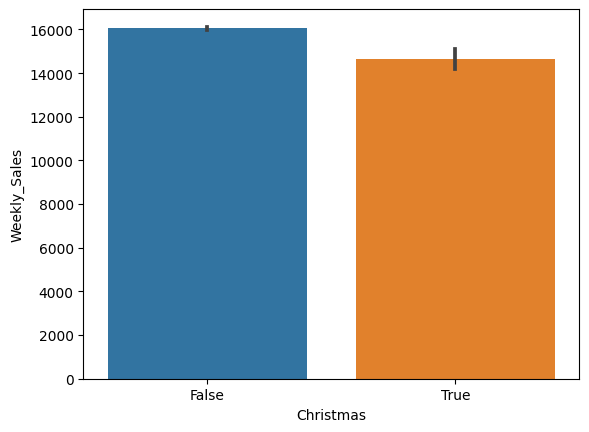

In [35]:
# Sales for Christmas weeks vs other days
sns.barplot(x='Christmas', y='Weekly_Sales', data=sales_df)

Above anlaysis shows that Thanksgiving has the most positive effect on sales, it will be due to black friday promotions, where as apart from Super bowl no other holiday shows positive trend for slaes

### Lets change date to date time to see further anlysis on sales

<Axes: xlabel='month'>

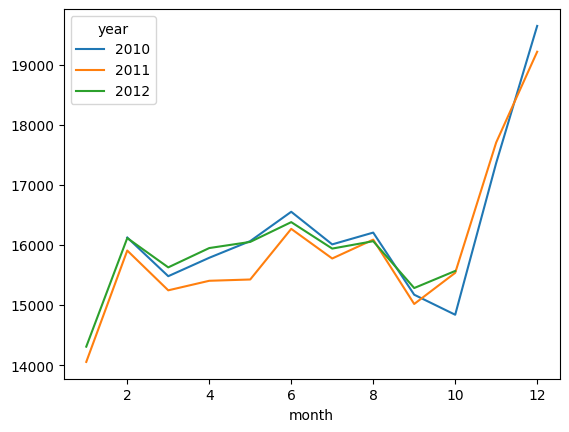

In [36]:
sales_df["Date"] = pd.to_datetime(sales_df["Date"])
sales_df['week'] =sales_df['Date'].dt.week
sales_df['month'] =sales_df['Date'].dt.month
sales_df['year'] =sales_df['Date'].dt.year
monthly_sales = pd.pivot_table(sales_df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

Looking at above graph the pattern for the sale across 3 different years is the same, the sales spike around the year end months

We know that other than holidays, gas prices, unemployment and temperature also affects the sales, lets see if that true in this case too

### Fuel price

<Axes: xlabel='Fuel_Price'>

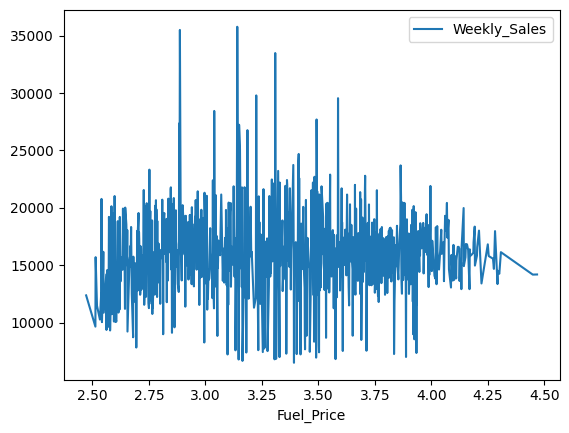

In [37]:
fuel_price = pd.pivot_table(sales_df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

### Temperature

<Axes: xlabel='Temperature'>

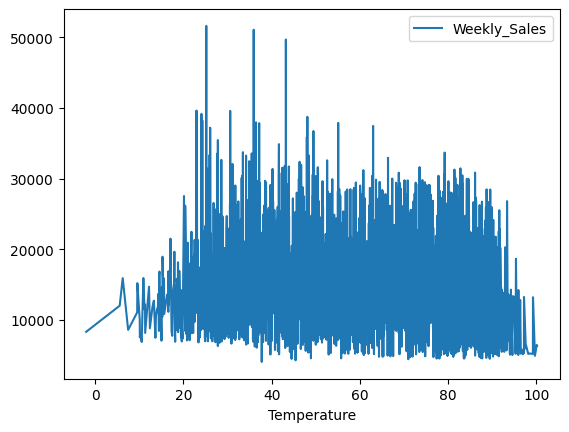

In [38]:
temp = pd.pivot_table(sales_df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

### Unemployment

<Axes: xlabel='Unemployment'>

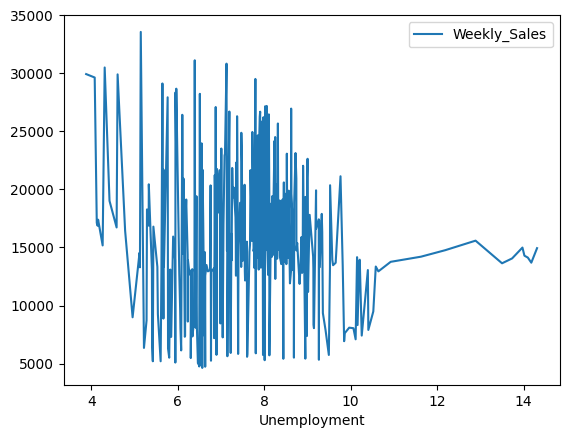

In [39]:
unemployment = pd.pivot_table(sales_df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

### Findings till now from our dat exploration

1. Our data was provided us in 4 csv's , we mergeed the store, features and train csv to make a complete data set
2. On looking at data further we found that we have markdown_columns which had many null values for we removed those columns form the data for better data quality for analysis.
3. We also found that there were some negative sales values for the sales for few rows, which is not possible for store like wlamart and should be a data glitch so we removed those rows from the dataset
4. We then looked at the attributes which can affect the sales, such as holidays, fuel price, unemployment, Temperature
5. we saw that holidays can be categorized into 4 different holidays a. Labor day, b. super bowl, thanks, giving and Chrtistmas out of which only thanks giving has a strong positive impact on sales and later super bowl has some positive impact on slaes, but Labor day and Christmas didnt had any psitive impact.
6. Looking at the other features affecting sales, we saw that we cannot make any positive or negative impact on slaes with these features.
#### 7. We also observered that for all three years the sales tends to increase at the end of year.

### Further steps

1. Now we hav a pretty clean data which we can use for further feture slection and modeling
2. But we still have some categorical, ordinal feilds which needs to be transformed for modeling
3. Also we need to see correlation of features with weekly sales

In [40]:
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


we need to convert columns Type, Holidays, and IsHoliday feature for model creation

In [41]:
sales_model_df = pd.get_dummies(sales_df, columns=['Type', 'IsHoliday','Super_Bowl','Labor_Day','Thanksgiving','Christmas'])

In [42]:
sales_model_df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,week,...,IsHoliday_False,IsHoliday_True,Super_Bowl_False,Super_Bowl_True,Labor_Day_False,Labor_Day_True,Thanksgiving_False,Thanksgiving_True,Christmas_False,Christmas_True
0,1,1,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,151315,5,...,1,0,1,0,1,0,1,0,1,0
1,1,2,2010-02-05,50605.27,42.31,2.572,211.096358,8.106,151315,5,...,1,0,1,0,1,0,1,0,1,0
2,1,3,2010-02-05,13740.12,42.31,2.572,211.096358,8.106,151315,5,...,1,0,1,0,1,0,1,0,1,0
3,1,4,2010-02-05,39954.04,42.31,2.572,211.096358,8.106,151315,5,...,1,0,1,0,1,0,1,0,1,0
4,1,5,2010-02-05,32229.38,42.31,2.572,211.096358,8.106,151315,5,...,1,0,1,0,1,0,1,0,1,0


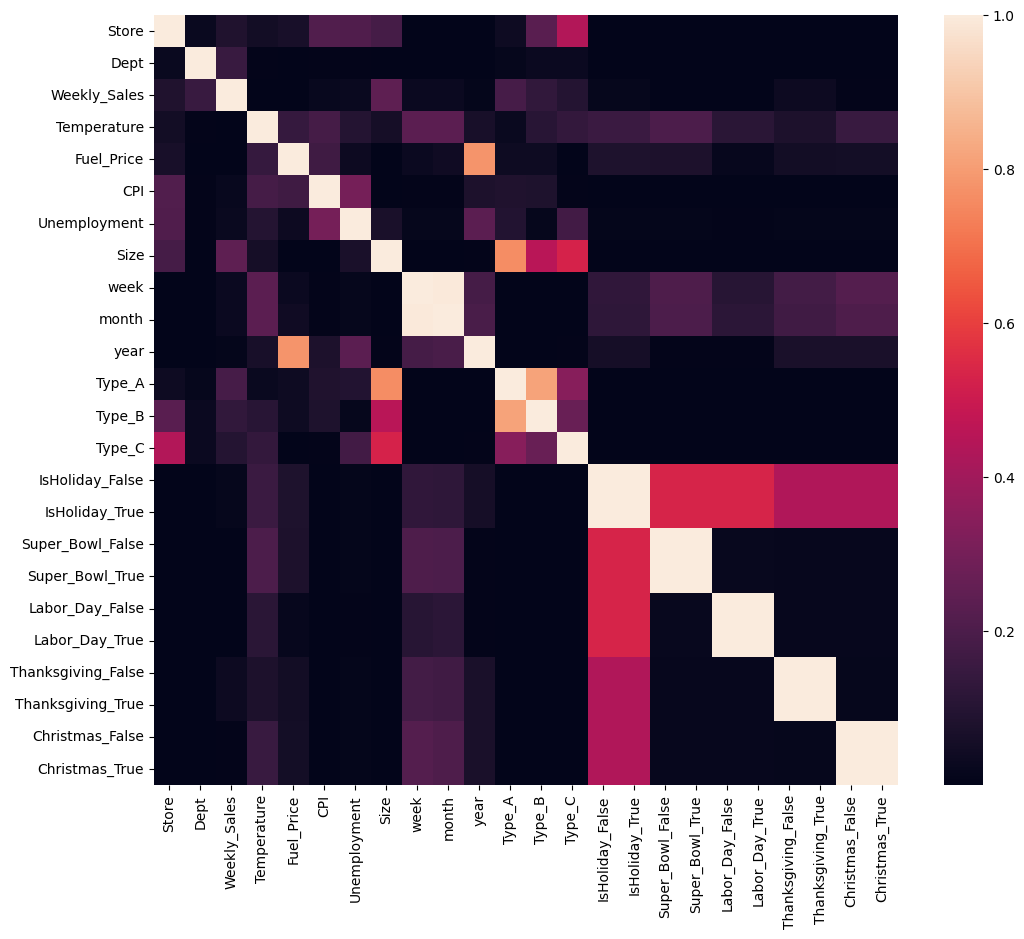

In [43]:
plt.figure(figsize = (12,10))
sns.heatmap(sales_model_df.corr().abs())    # To see the correlations
plt.show()

With respect to weekly sales we see that Size, type of store, department, store are highly corelated, but with previous anlsyis we have seen that holidays also somewhat play some role in weekly sales. But CPI and Unemployment didnt had much affect. So Let drop the CPI and unemployment columns for further model creation.

In [44]:
sales_model_df.drop(['CPI','Unemployment','Temperature'], axis=1, inplace=True)

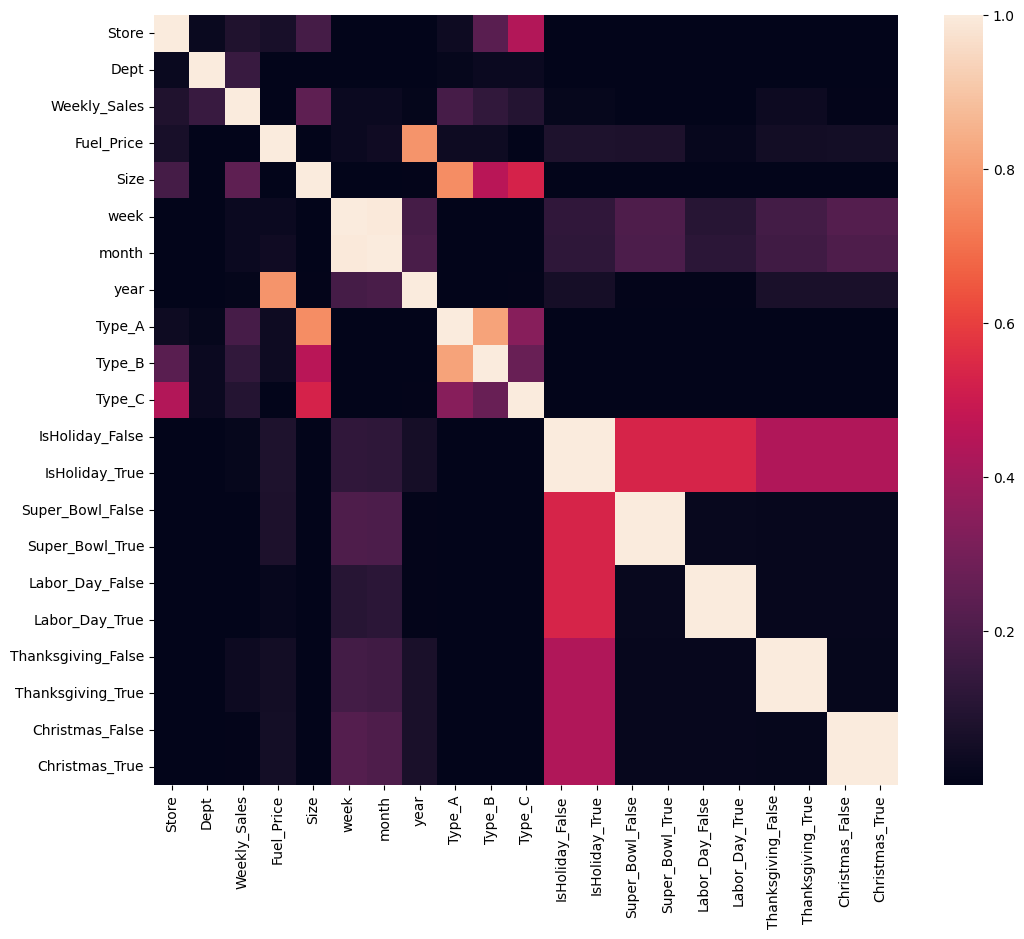

In [45]:
plt.figure(figsize = (12,10))
sns.heatmap(sales_model_df.corr().abs())    # To see the correlations
plt.show()

In [46]:
sales_model_df = sales_model_df.sort_values(by=['Date','Store','Dept'], ascending=True)

In [47]:
sales_model_df.head()

,Store,Dept,Date,Weekly_Sales,Fuel_Price,Size,week,month,year,Type_A,...,IsHoliday_False,IsHoliday_True,Super_Bowl_False,Super_Bowl_True,Labor_Day_False,Labor_Day_True,Thanksgiving_False,Thanksgiving_True,Christmas_False,Christmas_True
0,1,1,2010-02-05,24924.50,2.572,151315,5,2,2010,1,...,1,0,1,0,1,0,1,0,1,0
1,1,2,2010-02-05,50605.27,2.572,151315,5,2,2010,1,...,1,0,1,0,1,0,1,0,1,0
2,1,3,2010-02-05,13740.12,2.572,151315,5,2,2010,1,...,1,0,1,0,1,0,1,0,1,0
3,1,4,2010-02-05,39954.04,2.572,151315,5,2,2010,1,...,1,0,1,0,1,0,1,0,1,0
4,1,5,2010-02-05,32229.38,2.572,151315,5,2,2010,1,...,1,0,1,0,1,0,1,0,1,0


### Splitting data for time series modeling

As we needs continuos timeseries data we cannot split randomly, so slitting the data in continuous mode with 70% training data and 30% test data

In [48]:
train_data = sales_model_df[:int(0.7*(len(sales_model_df)))]
test_data = sales_model_df[int(0.7*(len(sales_model_df))):]

target = "Weekly_Sales"
used_cols = [c for c in sales_model_df.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [49]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

### Feature Selection

#### Ridge

In [50]:
ridge_param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_pipe = Pipeline([('scaler', StandardScaler()),('ridge',Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
train_preds = ridge_grid.predict(X_train)
test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, train_preds)
ridge_test_mse = mean_squared_error(y_test, test_preds)

In [51]:
from sklearn import set_config
set_config(display="diagram")
ridge_pipe

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [52]:
print('Training data mse: ', ridge_train_mse)
print('Testing data mse: ', ridge_test_mse)

Training data mse:  482103805.62342376
Testing data mse:  444506797.6831619


In [53]:
best_model = ridge_grid.best_estimator_
coefs = best_model.named_steps['ridge'].coef_
features = X_train.columns

print('Best_model: ', best_model)
coef_df = pd.DataFrame({'features': features, 'coefs': coefs})
coef_df.sort_values(by=['coefs'], ascending = False)

Best_model:  Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=1000.0))])


,features,coefs
3,Size,6111.455355
1,Dept,3272.028832
9,Type_C,1379.949679
5,month,1168.625192
2,Fuel_Price,701.886808
17,Thanksgiving_True,341.183575
18,Christmas_False,206.217420
14,Labor_Day_False,94.529108
13,Super_Bowl_True,80.195029
11,IsHoliday_True,62.867514


In [54]:
r = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=30,
    random_state=22,
    scoring='neg_mean_squared_error'
)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]} : "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Size : 73663404.289 +/- 675128.606
Dept : 23966202.892 +/- 296850.476
Store : 5440509.582 +/- 179566.791
Type_C : 4518730.235 +/- 145167.318
month : 884192.429 +/- 110500.216
week : 677551.526 +/- 40811.852
Type_B : 478886.728 +/- 44116.877
Type_A : 334070.412 +/- 46556.820
Fuel_Price : 235328.534 +/- 51785.721
Super_Bowl_True : 26413.466 +/- 10746.130
Super_Bowl_False : 26413.466 +/- 10746.130
IsHoliday_False : 14263.435 +/- 4812.539
IsHoliday_True : 14263.435 +/- 4812.539


<Figure size 640x480 with 0 Axes>

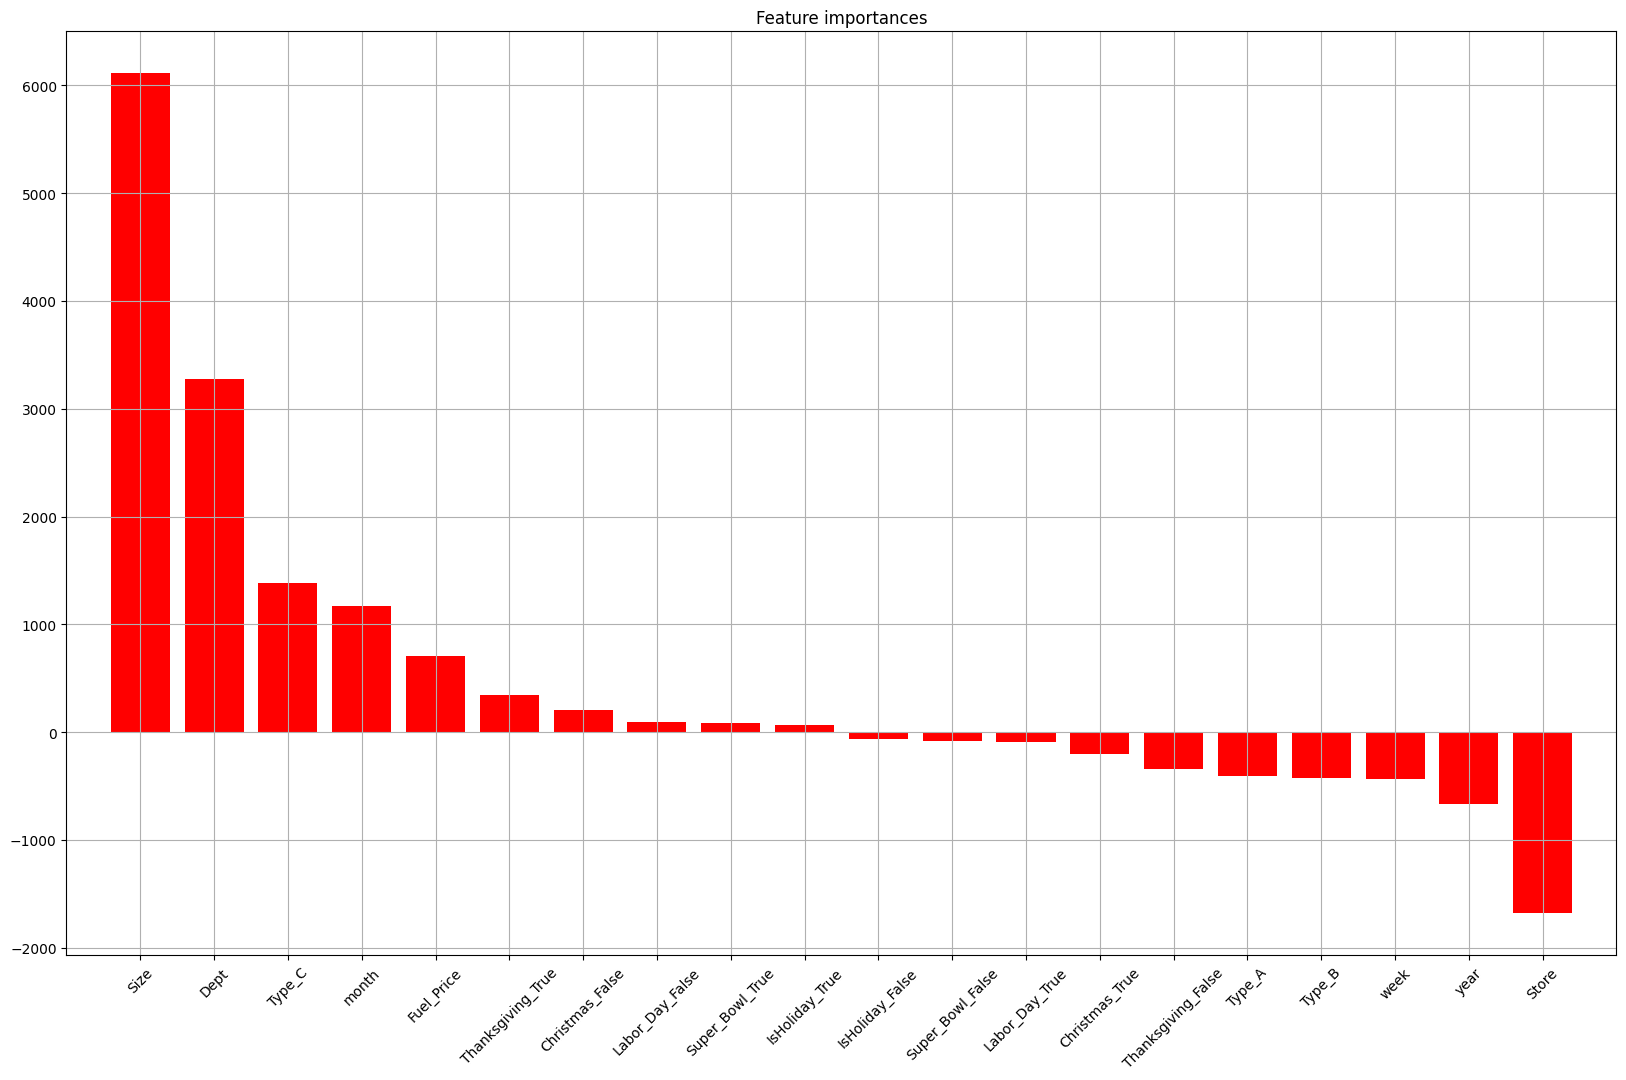

In [55]:
plt.figure()
plt.subplots(figsize=(20, 12))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), coef_df.sort_values(by=['coefs'], ascending = False)['coefs'],
       color="r",  align="center")
plt.xticks(range(X_train.shape[1]), coef_df.sort_values(by=['coefs'], ascending = False)['features'], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.grid()
plt.show()

### Timeseries Decomposition

In [56]:
sales_model_df["Date"] = pd.to_datetime(sales_model_df["Date"])

In [57]:
sales_model_df.set_index('Date', inplace=True)

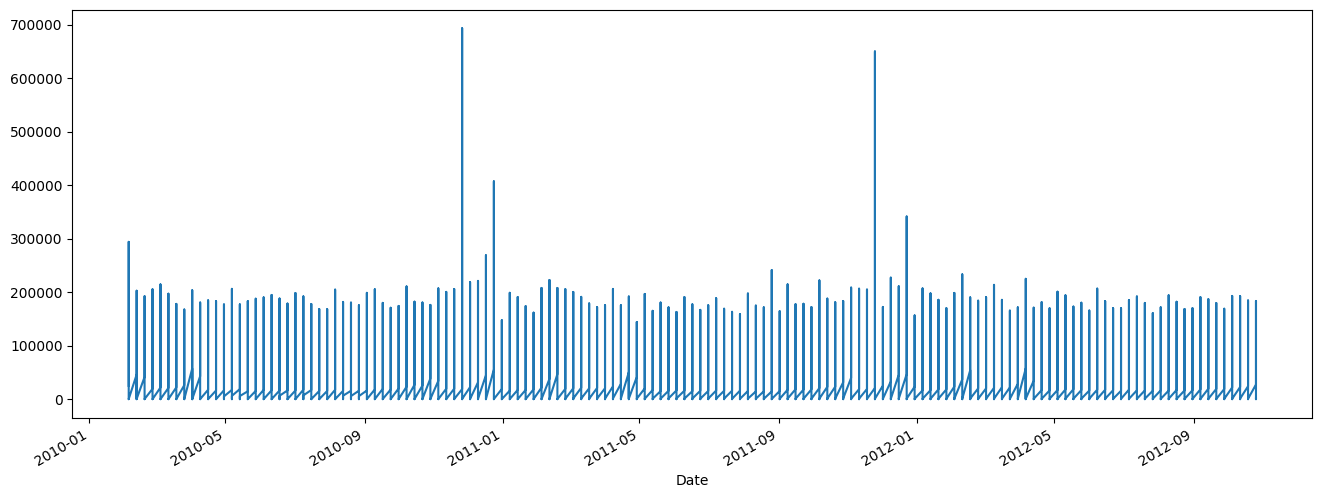

In [58]:
plt.figure(figsize=(16,6))
sales_model_df['Weekly_Sales'].plot()
plt.show()

In [59]:
sales_model_df_weeks = sales_model_df.resample('W').mean()

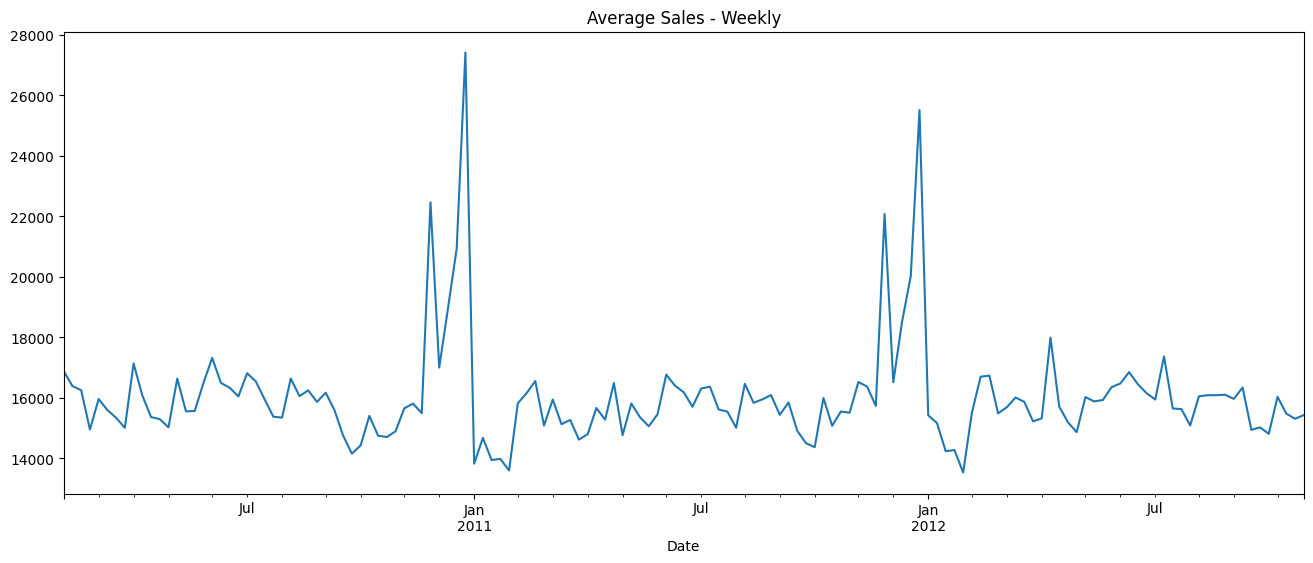

In [60]:
plt.figure(figsize=(16,6))
sales_model_df_weeks['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [61]:
sales_model_df_month = sales_model_df.resample('MS').mean()

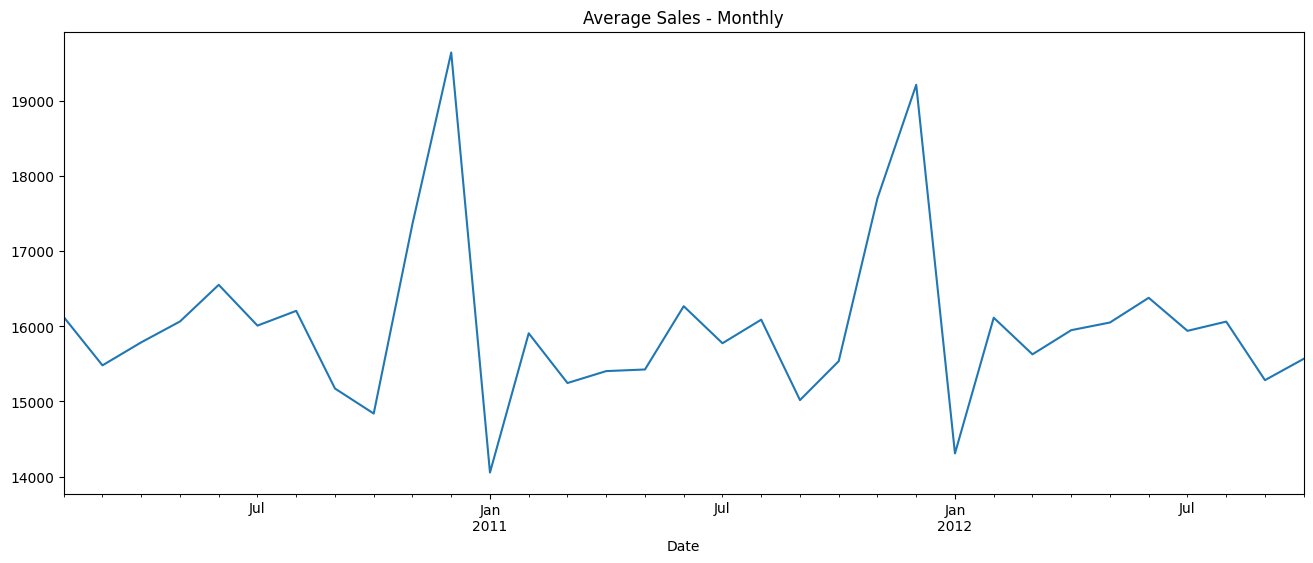

In [62]:
plt.figure(figsize=(16,6))
sales_model_df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

### Finding rolling mean Data

In [63]:
# finding 2-weeks rolling mean and std
roll_mean = sales_model_df_weeks['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = sales_model_df_weeks['Weekly_Sales'].rolling(window=2, center=False).std()

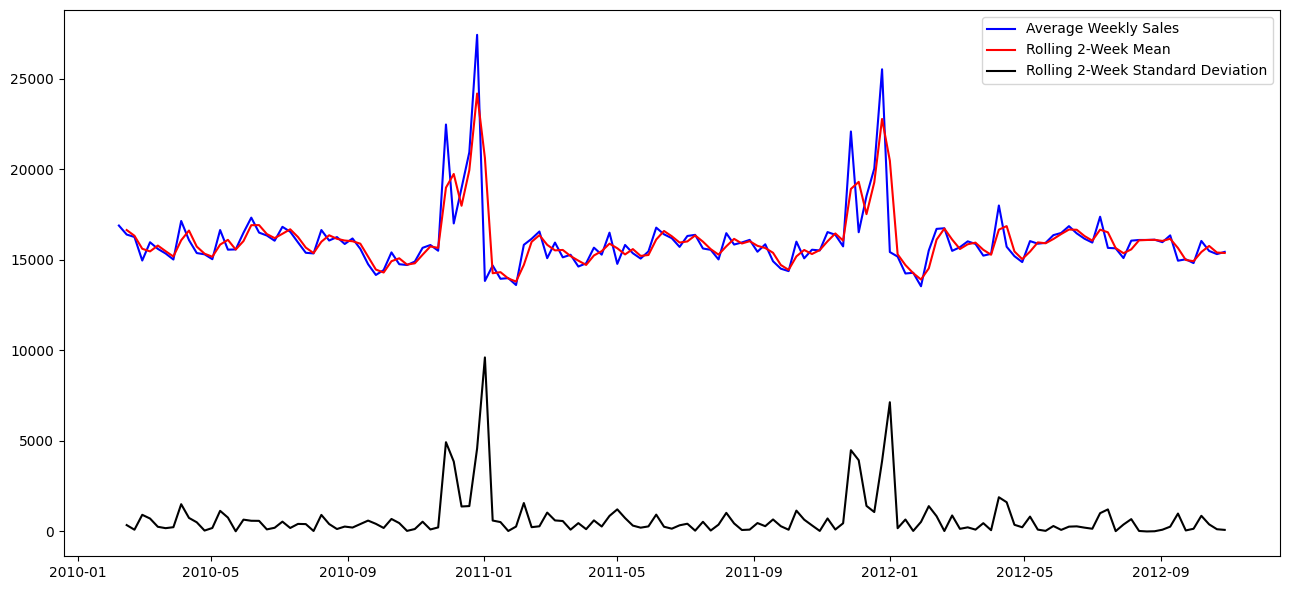

In [64]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(sales_model_df_weeks['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

### Adfuller Test

In [65]:
adfuller(sales_model_df_weeks['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

Above observations show that the data is non stationary

In [66]:
train_data = sales_model_df_weeks[:int(0.7*(len(sales_model_df_weeks)))]
test_data = sales_model_df_weeks[int(0.7*(len(sales_model_df_weeks))):]

target = "Weekly_Sales"
used_cols = [c for c in sales_model_df_weeks.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

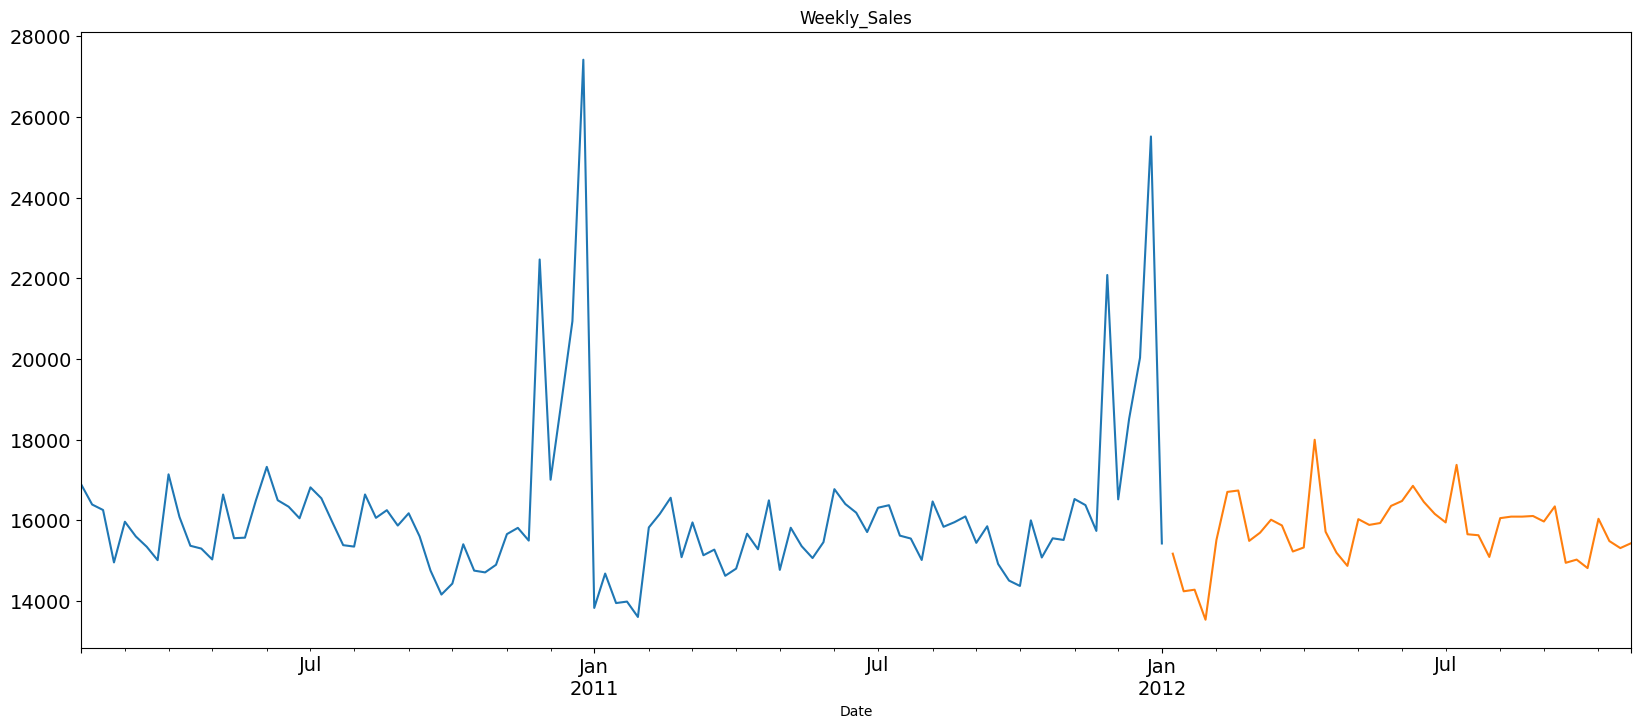

In [67]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [68]:
decomposed = decompose(sales_model_df_weeks['Weekly_Sales'].values, 'additive', m=20)

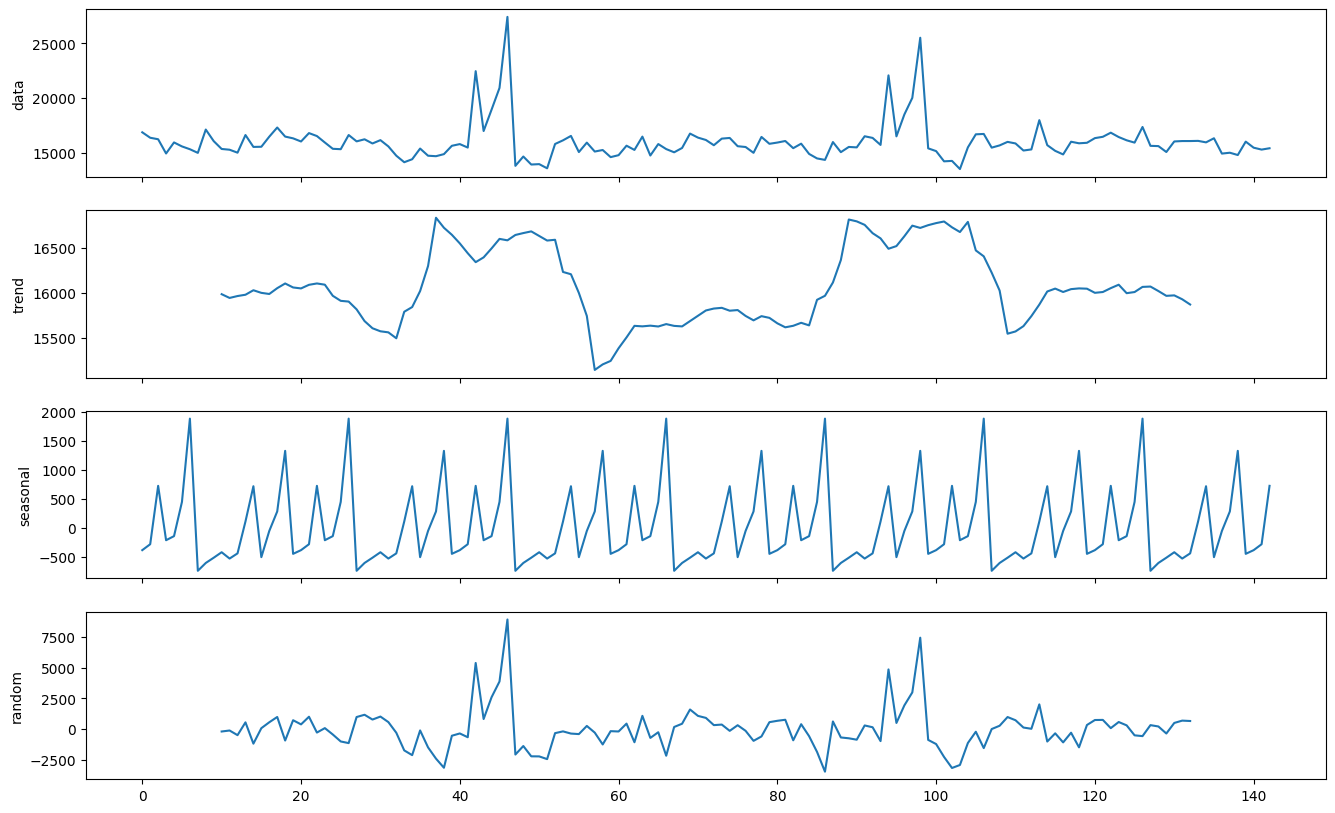

In [69]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From above we see that we have repetative pattern in the data every few steps

### Making Data Stationary

### Difference

In [70]:
df_week_diff = sales_model_df_weeks['Weekly_Sales'].diff().dropna()

In [71]:
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

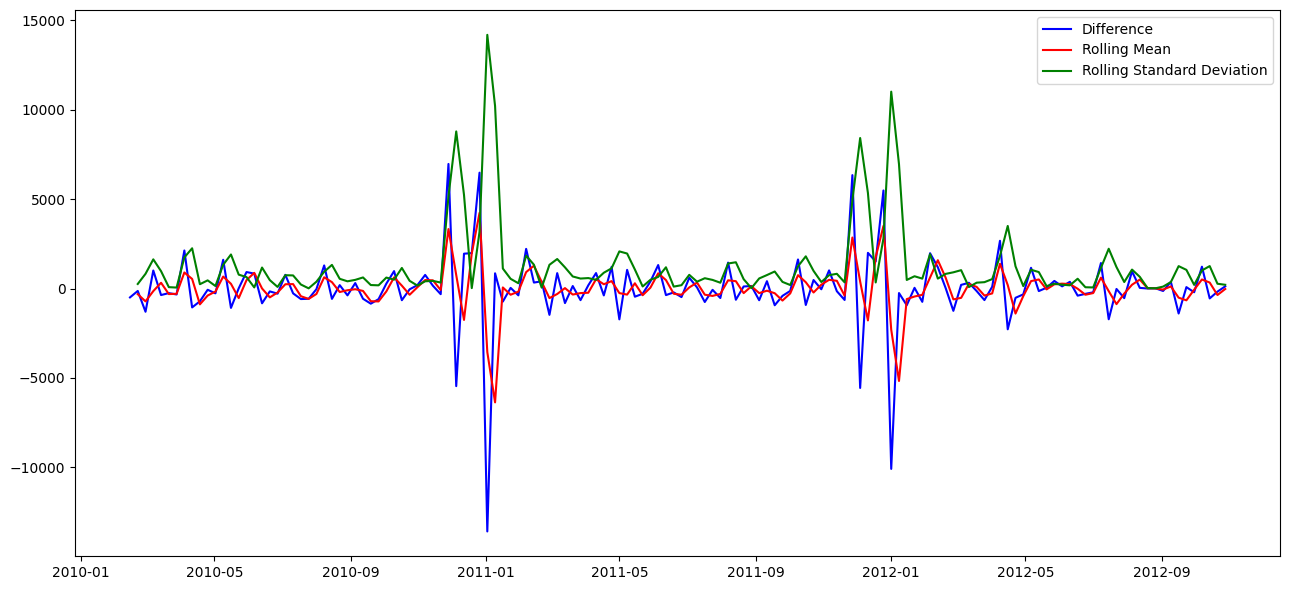

In [72]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='green', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()


### Shif

In [73]:
df_week_lag = sales_model_df_weeks['Weekly_Sales'].shift().dropna()

In [74]:
shift_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
shift_roll_std = df_week_lag.rolling(window=2, center=False).std()

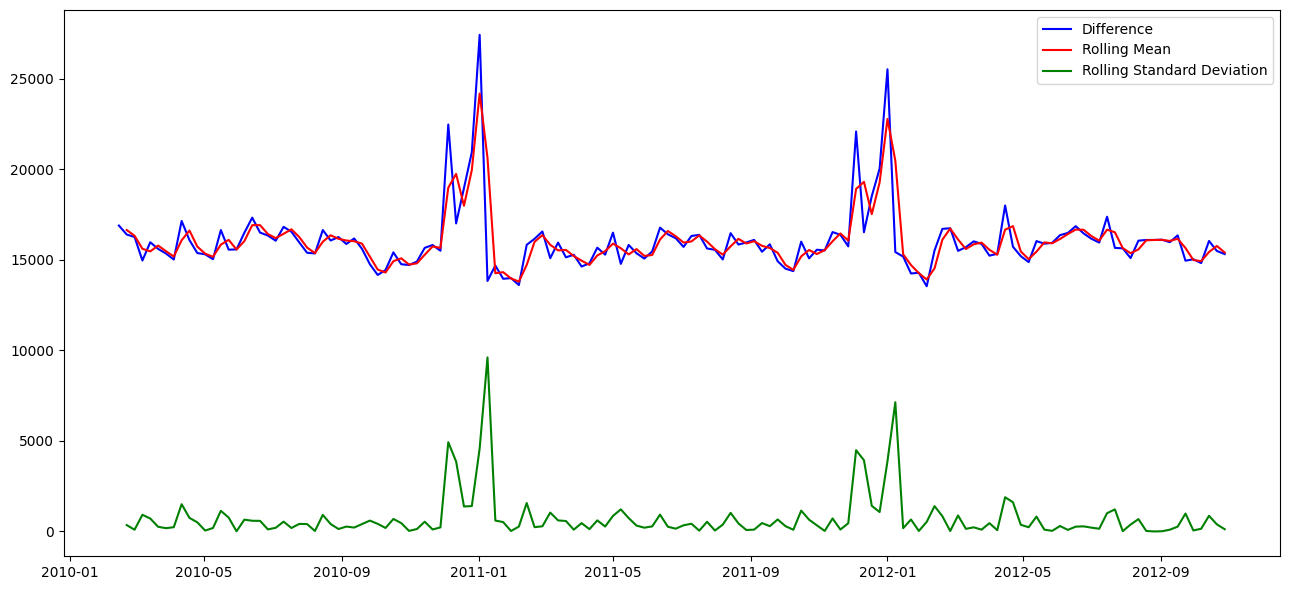

In [75]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(shift_roll_mean, color='red', label='Rolling Mean')
ax.plot(shift_roll_std, color='green', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()


### Log

In [76]:
logged_week = np.log1p(sales_model_df_weeks['Weekly_Sales']).dropna()

In [77]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

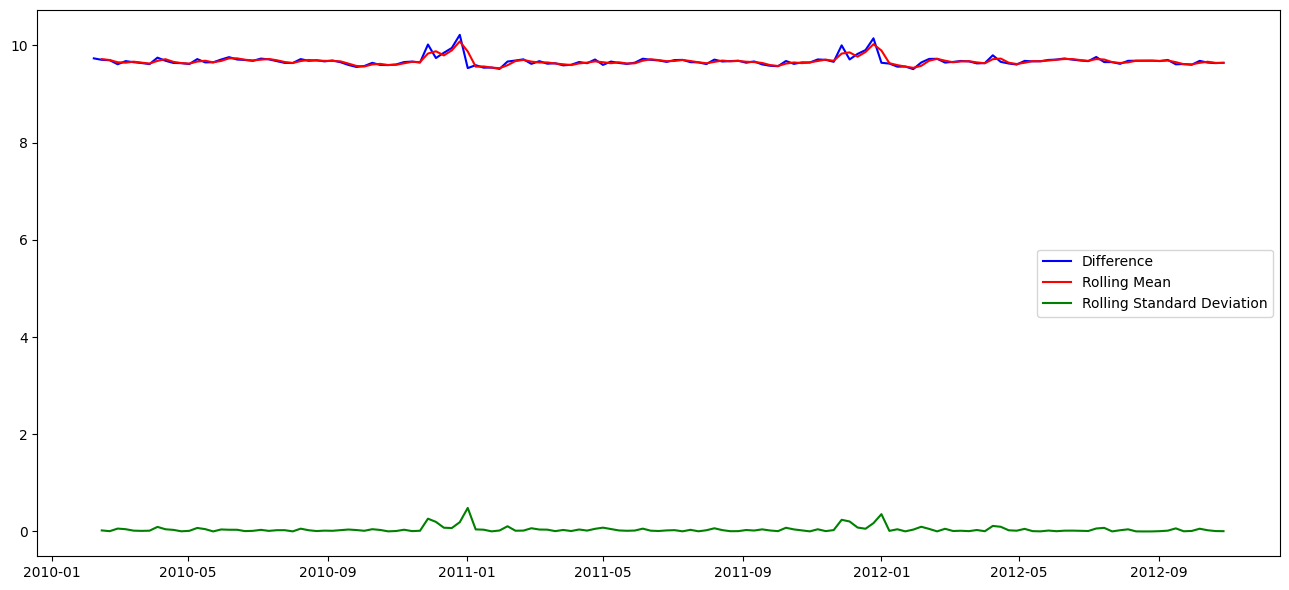

In [78]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Difference')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='green', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()


### From above 3 algorithms the differenceial data gave us the most stationary data

### Creating the final model

In [79]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [80]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.61 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.54 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

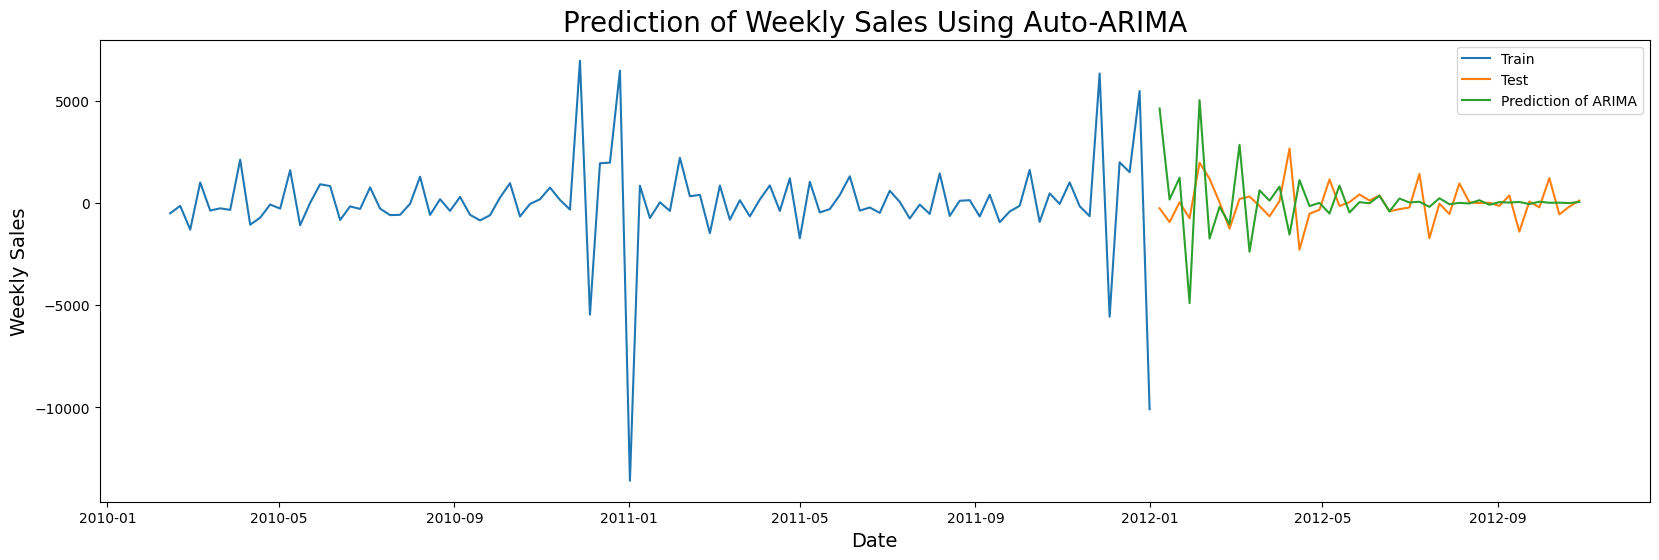

In [81]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

The predictions has little less trend than the test data. We can tune it further or use another algorithm to have a closer prediction as test data.